In [1]:
import tensorflow as tf
import os

2023-11-03 14:08:38.117035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # Avoid OOM errors by setting GPU memory consumption growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True) # to tell tensorflow to allocate memory as needed

In [3]:
import cv2

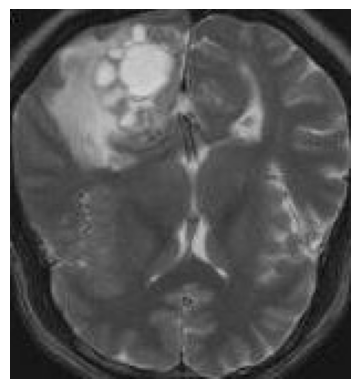

In [4]:
data_dir = 'preprocessed'
# open a random brain image, check if image has been processed
# grayscale -> gaussianBlur -> binary threshold -> erosion -> dilate -> contour
# Crop
img_raw = os.path.join(data_dir, 'malignant', 'y718.jpg')
img = cv2.imread(img_raw)

import matplotlib.pyplot as plt
# Convert image to normal
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Building the data pipeline
# Reshapes the images to the same size, and normalizes the pixel values to a range of 0 to 1.
data = tf.keras.utils.image_dataset_from_directory('preprocessed')
valid = tf.keras.utils.image_dataset_from_directory('valid')

Found 2904 files belonging to 2 classes.
Found 24 files belonging to 2 classes.


In [8]:
# Accessing the data pipeline
data_iterator = data.as_numpy_iterator()

In [9]:
# Accessing the data itself in the pipeline
batch = data_iterator.next()

In [10]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [11]:
# Class 0 means benign images and Class 1 means malignant
batch[1]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

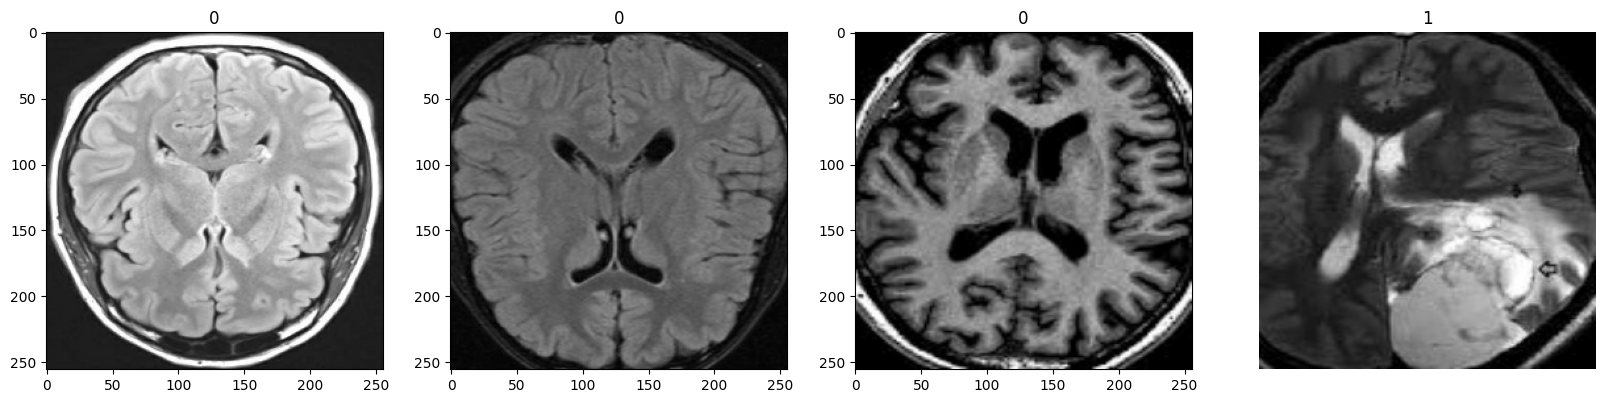

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
plt.axis('off')
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    plt.axis('off')

In [13]:
data = data.map(lambda x, y: (x/255, y))
valid = tf.keras.utils.image_dataset_from_directory('valid')
valid = valid.map(lambda x, y: (x/255, y))

Found 24 files belonging to 2 classes.


In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
batch = scaled_iterator.next()

In [16]:
batch[0].min()

0.0

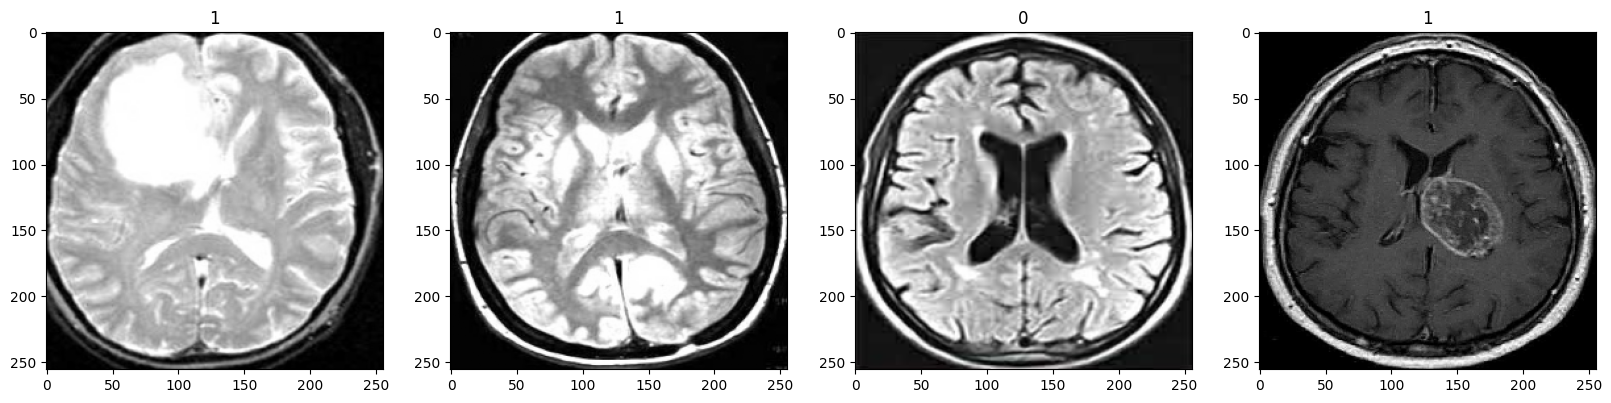

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [18]:
len(data)

91

In [19]:
train_size = int(len(data))
val_size = int(len(valid))

In [20]:
print(train_size)
print(val_size)

91
1


In [21]:
train = data.take(train_size)
validation = valid.take(val_size)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers 

# Set a lower learning rate
learning_rate = 0.0001
l2_lambda = 0.001

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(256, 256, 3)))
model.add(BatchNormalization())  # Batch normalization after activation
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [25]:
# Compile the model with a lower learning rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
91/91 [==============================] - 314s 3s/step - loss: 1.6311 - accuracy: 0.7762 - val_loss: 1.7481 - val_accuracy: 0.6667
Epoch 2/20
91/91 [==============================] - 339s 4s/step - loss: 1.2365 - accuracy: 0.9270 - val_loss: 1.7287 - val_accuracy: 0.6667
Epoch 3/20
91/91 [==============================] - 298s 3s/step - loss: 1.0640 - accuracy: 0.9663 - val_loss: 1.4572 - val_accuracy: 0.7083
Epoch 4/20
91/91 [==============================] - 293s 3s/step - loss: 0.9484 - accuracy: 0.9838 - val_loss: 1.5959 - val_accuracy: 0.4167
Epoch 5/20
91/91 [==============================] - 289s 3s/step - loss: 0.8557 - accuracy: 0.9948 - val_loss: 1.3326 - val_accuracy: 0.6667
Epoch 6/20
91/91 [==============================] - 280s 3s/step - loss: 0.7822 - accuracy: 0.9931 - val_loss: 0.9288 - val_accuracy: 0.8750
Epoch 7/20
91/91 [==============================] - 278s 3s/step - loss: 0.7074 - accuracy: 0.9983 - val_loss: 0.8342 - val_accuracy: 0.9167
Epoch 8/20
91

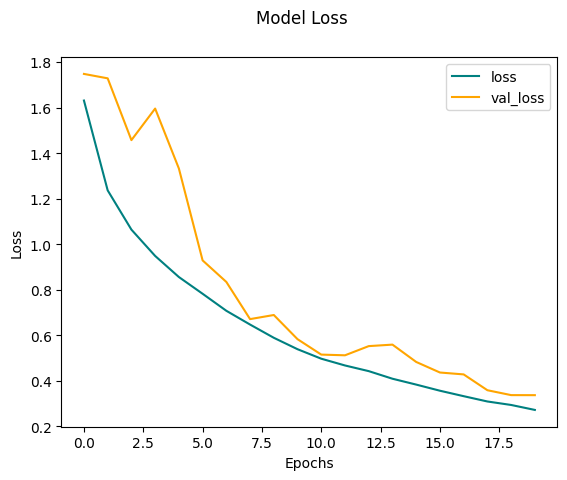

In [27]:
# Plot the model performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

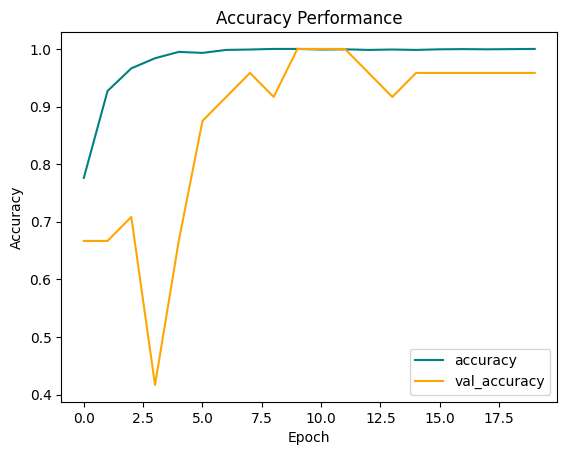

In [28]:
# Plot the accuracy performance
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [30]:
# Only if test set exists as tensors
# true_labels = []
# for image, label in test:
#     # `image` contains the image data
#     # `label` contains the label
#     print(f"Label: {label.numpy()}")
#     true_labels.append(label.numpy())

# true_labels = np.array(true_labels)
# print(true_labels)

In [31]:
test_dir = 'test'

In [32]:
test_images = []
true_labels = []
file_names = []

for label in os.listdir(test_dir):
    for file in os.listdir(os.path.join(test_dir, label)):
            img = cv2.imread(os.path.join(test_dir, label, file))
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resize = tf.image.resize(img, [256, 256])
            test_images.append(resize)
            true_labels.append(label)
            file_names.append(file)

In [33]:
print(len(test_images), len(true_labels), len(file_names))
print(true_labels)

# Get index of first weapon image
index = true_labels.index('malignant')
print(index, file_names[index])

47 47 47
['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign']
0 161.jpg


In [34]:
true = [1 if label == 'malignant' else 0 for label in true_labels]
true[15]

1

In [35]:
predictions = []
for predict in test_images:
    prediction = model.predict(np.expand_dims(predict/255, 0))
    predictions.append(prediction[0][0])

print(predictions)

1/1 [==============================] - 0s 58ms/step
[0.9822219, 0.98936695, 0.9870673, 0.98203385, 0.9916838, 0.72767645, 0.97782916, 0.99769413, 0.98757297, 0.9890943, 0.79795706, 0.9987094, 0.99089915, 0.9726301, 0.949386, 0.9903503, 0.69566095, 0.56006056, 0.98543096, 0.031218555, 0.33396453, 0.8015954, 0.9920673, 0.9976669, 0.9992907, 0.12659533, 0.92930645, 0.98425764, 0.9879777, 0.9909364, 0.98017776, 0.0060019456, 0.24584985, 0.0026805345, 0.0028140363, 0.018363182, 0.001995716, 0.13796501, 0.4929256, 0.0033638934, 0.5103241, 0.33040982, 0.048612744, 0.037557825, 0.03766591, 0.00039861095, 0.0034114055]


In [36]:
pred = [1 if prediction >= 0.5 else 0 for prediction in predictions]

In [37]:
# Calculate accuracy
accuracy = accuracy_score(true, pred) #  accuracy
print("Accuracy:", accuracy*100, '%')

# Generate a classification report
class_report = classification_report(true, pred)
print("Classification Report:\n", class_report)

# Create a confusion matrix
confusion = confusion_matrix(true, pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 91.48936170212765 %
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.97      0.90      0.93        31

    accuracy                           0.91        47
   macro avg       0.90      0.92      0.91        47
weighted avg       0.92      0.91      0.92        47

Confusion Matrix:
 [[15  1]
 [ 3 28]]


<Axes: >

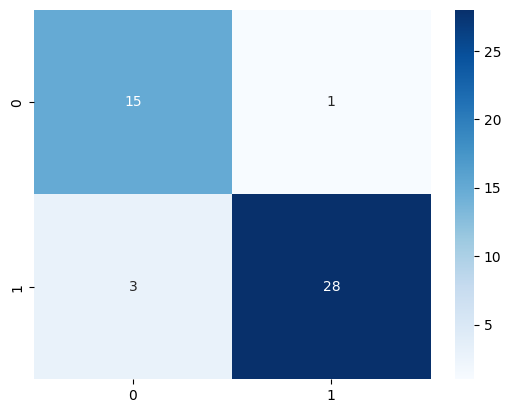

In [38]:
import seaborn as sns
sns.heatmap(confusion, annot=True, cmap='Blues')

In [39]:
model.save('simple_CNN_model.h5')

/Users/zannlim/Desktop/Y4S1/IT1244/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
